# ABBA test - 전력 사용량 예측

## import

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings(action='ignore')
from matplotlib import font_manager,rc
rc('font', family='AppleGothic')

## 데이터

### building_info

#### building_info 데이터 불러오기

In [78]:
# building_info 데이터 불러오기
building_info = pd.read_csv('input/building_info.csv')
display(building_info.head())
print(building_info.info())

건물번호  건물유형    연면적(m2)   냉방면적(m2) 태양광용량(kW) ESS저장용량(kWh) PCS용량(kW)
0     1  건물기타  110634.00   39570.00         -            -         -
1     2  건물기타  122233.47   99000.00         -            -         -
2     3  건물기타  171243.00  113950.00        40            -         -
3     4  건물기타   74312.98   34419.62        60            -         -
4     5  건물기타  205884.00  150000.00         -         2557      1000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB
None


#### column명 변환
- building_info의 column명을 편의를 위해 영어로 대체

In [79]:
# building_info의 column명을 편의를 위해 영어로 대체
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

####  building_type 변환
- building_info의 building_type column을 편의를 위해 영어로 대체

In [80]:
# building_info의 building_type column을 편의를 위해 영어로 대체
translation_dict = {
    '건물기타': 'Other_Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data_Center',
    '백화점및아울렛': 'Department_Store_and_Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research_Institute',
    '지식산업센터': 'Knowledge_Industry_Center',
    '할인마트': 'Discount_Mart',
    '호텔및리조트': 'Hotel_and_Resort'
}
building_info['building_type'] = building_info['building_type'].replace(translation_dict)
building_info

building_number     building_type  total_area  cooling_area  \
0                 1   Other_Buildings   110634.00      39570.00   
1                 2   Other_Buildings   122233.47      99000.00   
2                 3   Other_Buildings   171243.00     113950.00   
3                 4   Other_Buildings    74312.98      34419.62   
4                 5   Other_Buildings   205884.00     150000.00   
..              ...               ...         ...           ...   
95               96  Hotel_and_Resort    93314.00      60500.00   
96               97  Hotel_and_Resort    55144.67      25880.00   
97               98  Hotel_and_Resort    53578.62      17373.75   
98               99  Hotel_and_Resort    53499.00      40636.00   
99              100  Hotel_and_Resort    57497.84      40035.23   

   solar_power_capacity ess_capacity pcs_capacity  
0                     -            -            -  
1                     -            -            -  
2                    40            -            -  
3                    60            -            -  
4                     -         2557         1000  
..                  ...          ...          ...  
95                    -            -            -  
96                    -            -            -  
97                    -            -            -  
98                    -            -            -  
99                    -            -            -  

[100 rows x 7 columns]

#### 결측치 처리 
- solar_power_capacity, ess_capacity, pcs_capacity 컬럼의 '-' 로 되어있는 결측치를 0으로 바꿔주고 object로 되어있는 type을 float64로 변환

In [81]:
# solar_power_capacity, ess_capacity, pcs_capacity 컬럼의 '-' 로 되어있는 결측치를 0으로 바꿔주고 object로 되어있는 type을 float64로 변환
building_info = building_info.replace('-',0)
building_info[['solar_power_capacity','ess_capacity','pcs_capacity']] = building_info[['solar_power_capacity','ess_capacity','pcs_capacity']].astype('float64')
display(building_info)
print(building_info.info())

building_number     building_type  total_area  cooling_area  \
0                 1   Other_Buildings   110634.00      39570.00   
1                 2   Other_Buildings   122233.47      99000.00   
2                 3   Other_Buildings   171243.00     113950.00   
3                 4   Other_Buildings    74312.98      34419.62   
4                 5   Other_Buildings   205884.00     150000.00   
..              ...               ...         ...           ...   
95               96  Hotel_and_Resort    93314.00      60500.00   
96               97  Hotel_and_Resort    55144.67      25880.00   
97               98  Hotel_and_Resort    53578.62      17373.75   
98               99  Hotel_and_Resort    53499.00      40636.00   
99              100  Hotel_and_Resort    57497.84      40035.23   

    solar_power_capacity  ess_capacity  pcs_capacity  
0                    0.0           0.0           0.0  
1                    0.0           0.0           0.0  
2                   40.0           0.0           0.0  
3                   60.0           0.0           0.0  
4                    0.0        2557.0        1000.0  
..                   ...           ...           ...  
95                   0.0           0.0           0.0  
96                   0.0           0.0           0.0  
97                   0.0           0.0           0.0  
98                   0.0           0.0           0.0  
99                   0.0           0.0           0.0  

[100 rows x 7 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   building_number       100 non-null    int64  
 1   building_type         100 non-null    object 
 2   total_area            100 non-null    float64
 3   cooling_area          100 non-null    float64
 4   solar_power_capacity  100 non-null    float64
 5   ess_capacity          100 non-null    float64
 6   pcs_capacity          100 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ KB
None


### train_df

#### train_df 데이터 불러오기

In [82]:
# train_df 데이터 불러오기
train_df = pd.read_csv('input/train.csv')
display(train_df.head())
print(train_df.info())

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20220601 00     1  20220601 00   18.6      NaN      0.9   42.0     NaN   
1  1_20220601 01     1  20220601 01   18.0      NaN      1.1   45.0     NaN   
2  1_20220601 02     1  20220601 02   17.7      NaN      1.5   45.0     NaN   
3  1_20220601 03     1  20220601 03   16.7      NaN      1.4   48.0     NaN   
4  1_20220601 04     1  20220601 04   18.4      NaN      2.8   43.0     NaN   

   일사(MJ/m2)  전력소비량(kWh)  
0        NaN     1085.28  
1        NaN     1047.36  
2        NaN      974.88  
3        NaN      953.76  
4        NaN      986.40

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB
None


#### column명 변환
- train_df의 column명을 편의를 위해 영어로 대체

In [83]:
# train_df의 column명을 편의를 위해 영어로 대체
train_df = train_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})

#### 중복 column drop
- num_date_time 컬럼은 building_number와 date_time를 단순 합쳐좋은 데이터임으로 drop

In [84]:
# num_date_time 컬럼은 building_number와 date_time를 단순 합쳐좋은 데이터임으로 drop
train_df = train_df.drop('num_date_time', axis = 1)
train_df

building_number    date_time  temperature  rainfall  windspeed  \
0                     1  20220601 00         18.6       NaN        0.9   
1                     1  20220601 01         18.0       NaN        1.1   
2                     1  20220601 02         17.7       NaN        1.5   
3                     1  20220601 03         16.7       NaN        1.4   
4                     1  20220601 04         18.4       NaN        2.8   
...                 ...          ...          ...       ...        ...   
203995              100  20220824 19         23.1       NaN        0.9   
203996              100  20220824 20         22.4       NaN        1.3   
203997              100  20220824 21         21.3       NaN        1.0   
203998              100  20220824 22         21.0       NaN        0.3   
203999              100  20220824 23         20.7       NaN        0.1   

        humidity  sunshine  solar_radiation  power_consumption  
0           42.0       NaN              NaN            1085.28  
1           45.0       NaN              NaN            1047.36  
2           45.0       NaN              NaN             974.88  
3           48.0       NaN              NaN             953.76  
4           43.0       NaN              NaN             986.40  
...          ...       ...              ...                ...  
203995      86.0       0.5              NaN             881.04  
203996      86.0       0.0              NaN             798.96  
203997      92.0       NaN              NaN             825.12  
203998      94.0       NaN              NaN             640.08  
203999      95.0       NaN              NaN             540.24  

[204000 rows x 9 columns]

In [85]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   building_number    204000 non-null  int64  
 1   date_time          204000 non-null  object 
 2   temperature        204000 non-null  float64
 3   rainfall           43931 non-null   float64
 4   windspeed          203981 non-null  float64
 5   humidity           203991 non-null  float64
 6   sunshine           128818 non-null  float64
 7   solar_radiation    116087 non-null  float64
 8   power_consumption  204000 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 14.0+ MB


#### date_time 형식 변경 및 분활

In [86]:
# 형식 변경: 20220601 00 -> 2022-06-01 00:00:00
# object -> datetime64
train_df['date_time'] = pd.to_datetime(train_df['date_time'], format='%Y%m%d %H')

# date time feature 생성
train_df['year'] = train_df['date_time'].dt.year
train_df['month'] = train_df['date_time'].dt.month
train_df['day'] = train_df['date_time'].dt.day
train_df['hour'] = train_df['date_time'].dt.hour
train_df

building_number           date_time  temperature  rainfall  windspeed  \
0                     1 2022-06-01 00:00:00         18.6       NaN        0.9   
1                     1 2022-06-01 01:00:00         18.0       NaN        1.1   
2                     1 2022-06-01 02:00:00         17.7       NaN        1.5   
3                     1 2022-06-01 03:00:00         16.7       NaN        1.4   
4                     1 2022-06-01 04:00:00         18.4       NaN        2.8   
...                 ...                 ...          ...       ...        ...   
203995              100 2022-08-24 19:00:00         23.1       NaN        0.9   
203996              100 2022-08-24 20:00:00         22.4       NaN        1.3   
203997              100 2022-08-24 21:00:00         21.3       NaN        1.0   
203998              100 2022-08-24 22:00:00         21.0       NaN        0.3   
203999              100 2022-08-24 23:00:00         20.7       NaN        0.1   

        humidity  sunshine  solar_radiation  power_consumption  year  month  \
0           42.0       NaN              NaN            1085.28  2022      6   
1           45.0       NaN              NaN            1047.36  2022      6   
2           45.0       NaN              NaN             974.88  2022      6   
3           48.0       NaN              NaN             953.76  2022      6   
4           43.0       NaN              NaN             986.40  2022      6   
...          ...       ...              ...                ...   ...    ...   
203995      86.0       0.5              NaN             881.04  2022      8   
203996      86.0       0.0              NaN             798.96  2022      8   
203997      92.0       NaN              NaN             825.12  2022      8   
203998      94.0       NaN              NaN             640.08  2022      8   
203999      95.0       NaN              NaN             540.24  2022      8   

        day  hour  
0         1     0  
1         1     1  
2         1     2  
3         1     3  
4         1     4  
...     ...   ...  
203995   24    19  
203996   24    20  
203997   24    21  
203998   24    22  
203999   24    23  

[204000 rows x 13 columns]

### test_df

#### test_df 데이터 불러오기

In [87]:
# test_df 데이터 불러오기
test_df = pd.read_csv('input/test.csv')
display(test_df.head())
print(test_df.info())

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)
0  1_20220825 00     1  20220825 00   23.5      0.0      2.2     72
1  1_20220825 01     1  20220825 01   23.0      0.0      0.9     72
2  1_20220825 02     1  20220825 02   22.7      0.0      1.5     75
3  1_20220825 03     1  20220825 03   22.1      0.0      1.3     78
4  1_20220825 04     1  20220825 04   21.8      0.0      1.0     77

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB
None


#### column명 변환
- test_df의 column명을 편의를 위해 영어로 대체

In [88]:
# test_df의 column명을 편의를 위해 영어로 대체
test_df = test_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})

#### 중복 column drop
- num_date_time 컬럼은 building_number와 date_time를 단순 합쳐좋은 데이터임으로 drop

In [89]:
# num_date_time 컬럼은 building_number와 date_time를 단순 합쳐좋은 데이터임으로 drop
test_df = test_df.drop('num_date_time', axis = 1)
test_df

building_number    date_time  temperature  rainfall  windspeed  \
0                    1  20220825 00         23.5       0.0        2.2   
1                    1  20220825 01         23.0       0.0        0.9   
2                    1  20220825 02         22.7       0.0        1.5   
3                    1  20220825 03         22.1       0.0        1.3   
4                    1  20220825 04         21.8       0.0        1.0   
...                ...          ...          ...       ...        ...   
16795              100  20220831 19         22.5       0.0        0.9   
16796              100  20220831 20         20.7       0.0        0.4   
16797              100  20220831 21         20.2       0.0        0.4   
16798              100  20220831 22         20.1       0.0        1.1   
16799              100  20220831 23         19.1       0.0        0.1   

       humidity  
0            72  
1            72  
2            75  
3            78  
4            77  
...         ...  
16795        84  
16796        95  
16797        98  
16798        97  
16799        99  

[16800 rows x 6 columns]

#### date_time 형식 변경 및 분활

In [90]:
# 형식 변경: 20220601 00 -> 2022-06-01 00:00:00
# object -> datetime64
test_df['date_time'] = pd.to_datetime(test_df['date_time'], format='%Y%m%d %H')

# date time feature 생성
test_df['year'] = test_df['date_time'].dt.year
test_df['month'] = test_df['date_time'].dt.month
test_df['day'] = test_df['date_time'].dt.day
test_df['hour'] = test_df['date_time'].dt.hour
test_df

building_number           date_time  temperature  rainfall  windspeed  \
0                    1 2022-08-25 00:00:00         23.5       0.0        2.2   
1                    1 2022-08-25 01:00:00         23.0       0.0        0.9   
2                    1 2022-08-25 02:00:00         22.7       0.0        1.5   
3                    1 2022-08-25 03:00:00         22.1       0.0        1.3   
4                    1 2022-08-25 04:00:00         21.8       0.0        1.0   
...                ...                 ...          ...       ...        ...   
16795              100 2022-08-31 19:00:00         22.5       0.0        0.9   
16796              100 2022-08-31 20:00:00         20.7       0.0        0.4   
16797              100 2022-08-31 21:00:00         20.2       0.0        0.4   
16798              100 2022-08-31 22:00:00         20.1       0.0        1.1   
16799              100 2022-08-31 23:00:00         19.1       0.0        0.1   

       humidity  year  month  day  hour  
0            72  2022      8   25     0  
1            72  2022      8   25     1  
2            75  2022      8   25     2  
3            78  2022      8   25     3  
4            77  2022      8   25     4  
...         ...   ...    ...  ...   ...  
16795        84  2022      8   31    19  
16796        95  2022      8   31    20  
16797        98  2022      8   31    21  
16798        97  2022      8   31    22  
16799        99  2022      8   31    23  

[16800 rows x 10 columns]

## 데이터 시각화

power_consumption              
                  max           sum
day                                
1             25247.6  1.742705e+07
2             24861.2  1.750721e+07
3             25298.0  1.756725e+07
4             25342.8  1.802459e+07
5             25242.0  1.792036e+07
6             25488.4  1.710608e+07
7             25160.8  1.760577e+07
8             25130.0  1.816442e+07
9             24654.0  1.754747e+07
10            23612.4  1.717800e+07
11            23923.2  1.751058e+07
12            24273.2  1.747782e+07
13            23164.4  1.731388e+07
14            23679.6  1.718224e+07
15            22724.8  1.726088e+07
16            23598.4  1.733731e+07
17            23662.8  1.717613e+07
18            22568.0  1.740101e+07
19            23808.4  1.756384e+07
20            23951.2  1.780909e+07
21            23248.4  1.765295e+07
22            23993.2  1.840616e+07
23            22808.8  1.776209e+07
24            22262.8  1.717677e+07
25            24018.4  1.153101e+07
26            24494.4  1.158541e+07
27            24544.8  1.259611e+07
28            24861.2  1.284238e+07
29            24976.0  1.295444e+07
30            23909.2  1.188950e+07
31            17360.0  5.533618e+06

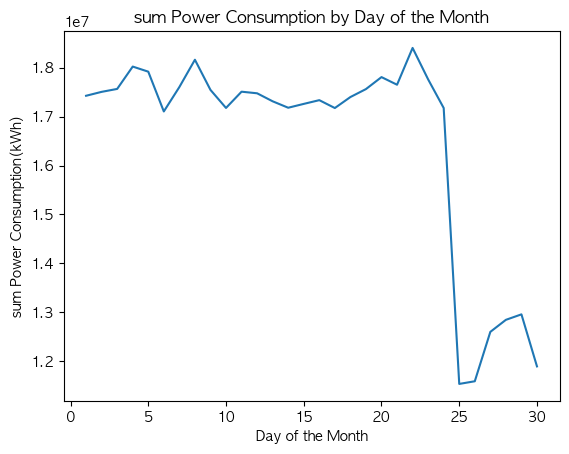

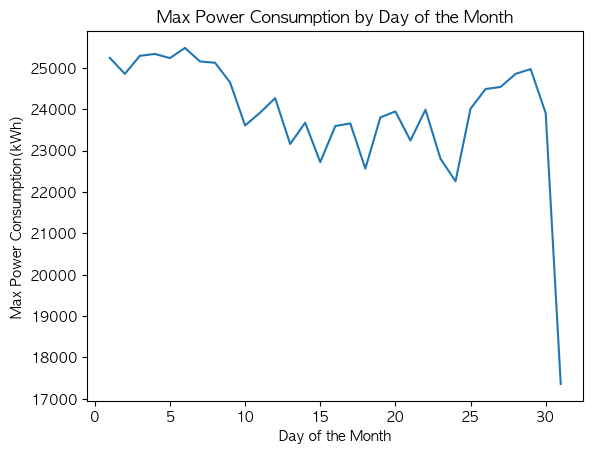

In [122]:
pt = pd.pivot_table(train_df, values=['power_consumption'], index=['day'], aggfunc={'power_consumption': [np.sum, max]})
display(pt)
plt.plot(mean_power_by_day.index[:-1],pt.power_consumption['sum'][:-1])
plt.title('sum Power Consumption by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('sum Power Consumption(kWh)')
plt.show()

plt.plot(mean_power_by_day.index,pt.power_consumption['max'])
plt.title('Max Power Consumption by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Max Power Consumption(kWh)')
plt.show()

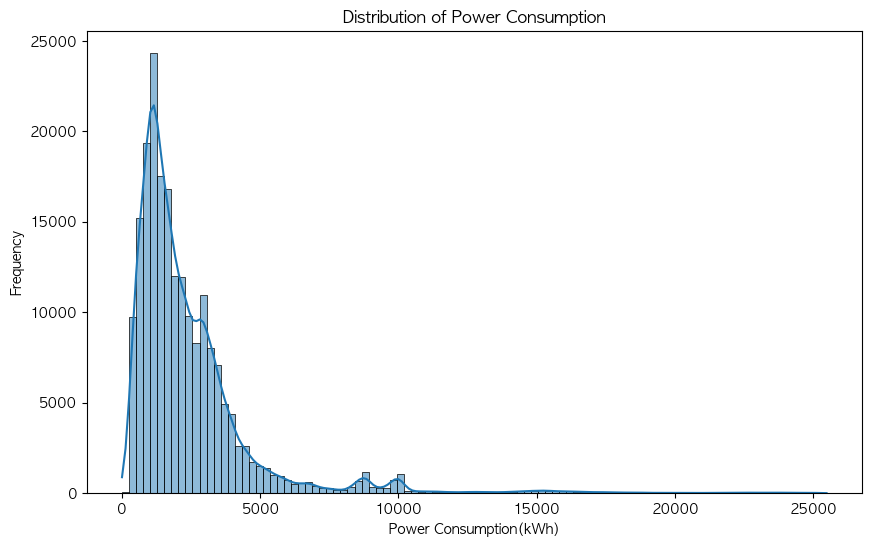

In [91]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['power_consumption'], bins=100, kde=True)
plt.title('Distribution of Power Consumption')
plt.xlabel('Power Consumption(kWh)')
plt.ylabel('Frequency')
plt.show()

In [92]:
# 년기준 일 평균 소비전력
train_df['day_of_year'] = train_df['date_time'].dt.dayofyear
mean_power_by_day_of_year = train_df.groupby('day_of_year')['power_consumption'].mean()
# 년기준 시간평균 소비전력
train_df['hour_of_year'] = train_df['date_time'].dt.hour + (train_df['date_time'].dt.dayofyear - 1) * 24
mean_power_by_hour_of_year = train_df.groupby('hour_of_year')['power_consumption'].mean()

# 년기준 월평균 소비전력
mean_power_by_month = train_df.groupby('month')['power_consumption'].mean()

# 일기준 시간 평균 소비전력
mean_power_by_hour = train_df.groupby('hour')['power_consumption'].mean()

# 월기준 시간 평균 소비전력
mean_power_by_day = train_df.groupby('day')['power_consumption'].mean()

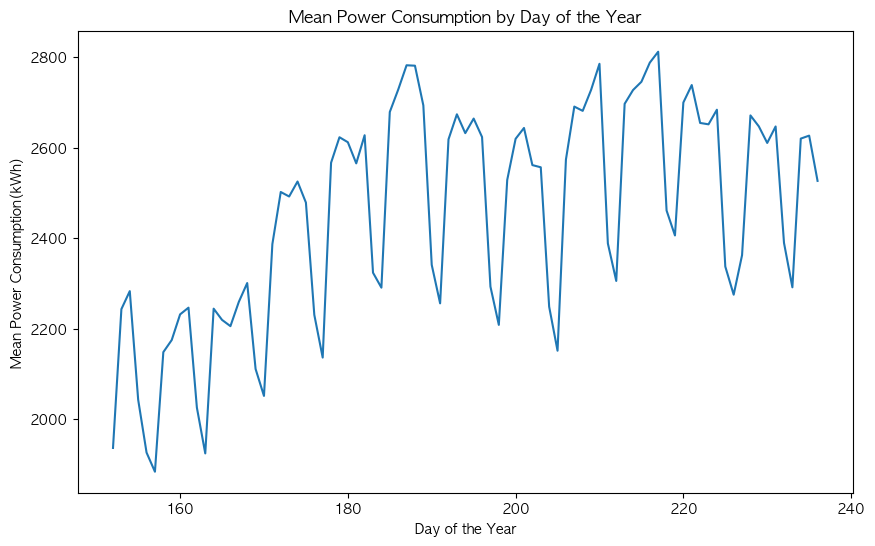

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(mean_power_by_day_of_year.index,mean_power_by_day_of_year.values)
plt.title('Mean Power Consumption by Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Mean Power Consumption(kWh)')
plt.show()

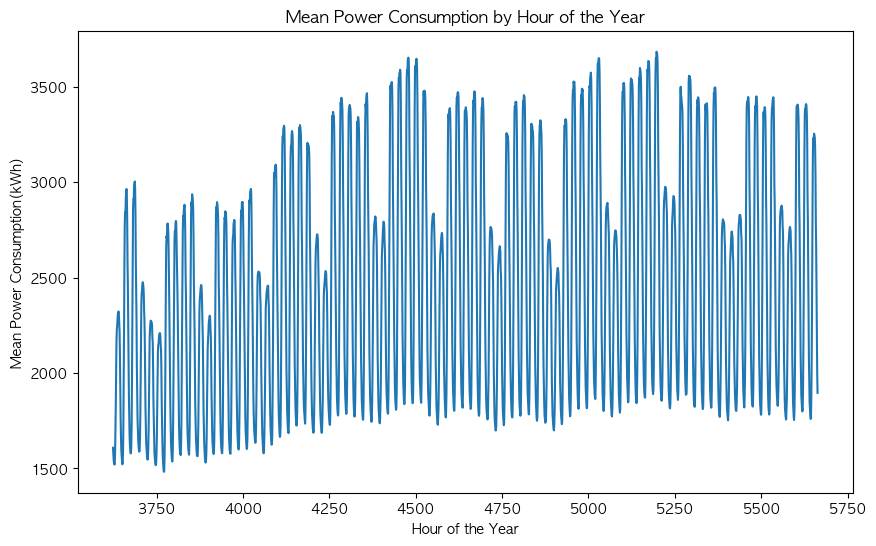

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(mean_power_by_hour_of_year.index,mean_power_by_hour_of_year.values)
plt.title('Mean Power Consumption by Hour of the Year')
plt.xlabel('Hour of the Year')
plt.ylabel('Mean Power Consumption(kWh)')
plt.show()

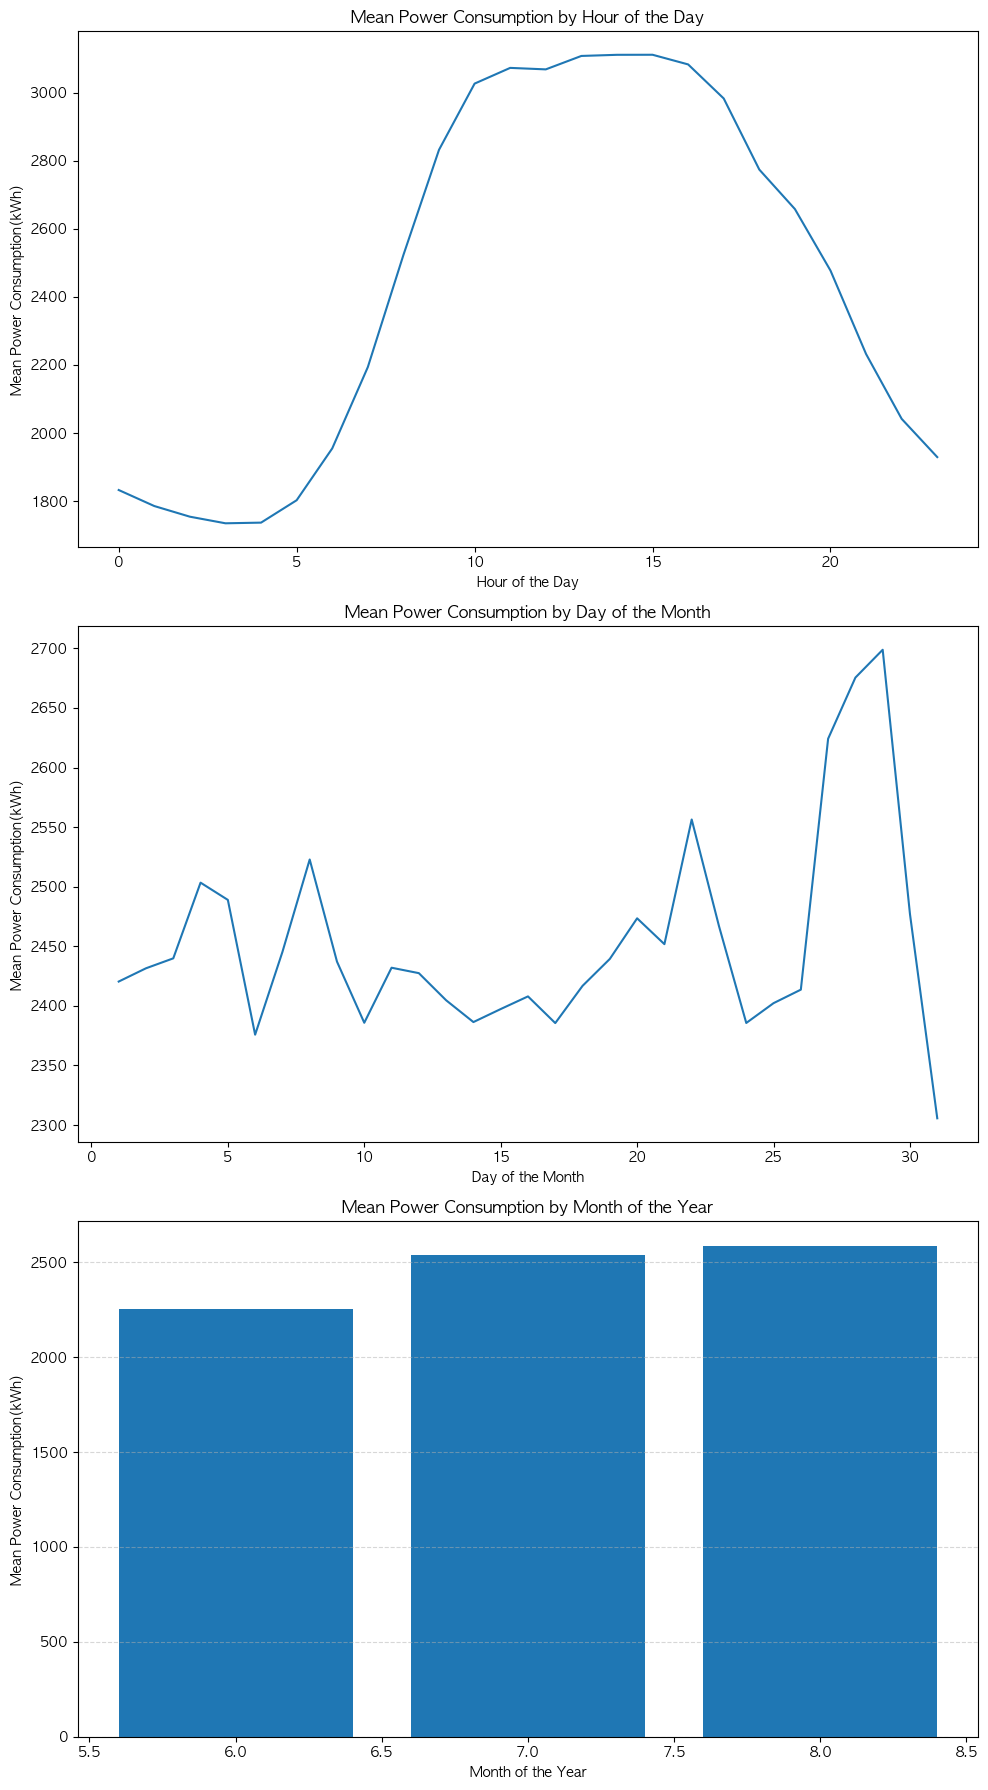

In [95]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot mean power consumption by hour of the day
axs[0].plot(mean_power_by_hour.index,mean_power_by_hour.values)
axs[0].set_title('Mean Power Consumption by Hour of the Day')
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Mean Power Consumption(kWh)')

# Plot mean power consumption by day of the month
axs[1].plot(mean_power_by_day.index,mean_power_by_day.values)
axs[1].set_title('Mean Power Consumption by Day of the Month')
axs[1].set_xlabel('Day of the Month')
axs[1].set_ylabel('Mean Power Consumption(kWh)')

# 년기준 월평균 소비전력
axs[2].bar(mean_power_by_month.index,mean_power_by_month.values)
axs[2].set_title('Mean Power Consumption by Month of the Year')
axs[2].set_xlabel('Month of the Year')
axs[2].set_ylabel('Mean Power Consumption(kWh)')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()